#### PHY 480 Semester Project
### &#9989; Bergen Kendziorski

#### &#9989; Last Updated on 4/20/24

# Molecular Dynamics of Argon

##  Introduction

The goal of this project was to create a functional molecular dynamics simulation in order to extract useful properties of argon. The concept of molecular dynamics was started in the 1950's, aimed to simulate systems with large numbers of atoms utilizing the increasing amount of available computational power.$^{[1]}$ These systems could not be solved analytically, as there is no analytical solution due to the large number of particles, each with the possibility of interacting with each other.$^{[2]}$ The basic idea behind molecular dynamics is to simulate the movement of atoms/molecules by solving Newton's equations of motion for the force between them.$^{[2]}$ For the course of this project, I'll be using the Lennard-Jones Potential for the interactions between atoms, as this does a good job of modeling the Van der Walls force.$^{[3]}$ I'll focus on using argon as the interacting particles, as this potential was originally designed for noble gases.$^{[4]}$

The Lennard-Jones potential is defined as: $V(r) = 4\epsilon[(\sigma/r)^{12} - (\sigma/r)^{6}]$ if $r \leq r_c$ where $r_c$ is a cutoff radius, and $V(r) = 0$ if $r \gt r_c$. - via source 3.

From this, the force felt by a particle due to another is simply the negative partial derivative of the Lennard-Jones potential with respect to r.

Therefore $F(r) = 4\epsilon[12\sigma^{12}/r^{13} - 6\sigma^{6}/r^{7}]$ if $r \leq r_c$, and F(r) = 0 otherwise.

In order to both test if my code is working as well as to provide a real-world reasoning for doing the simulations in the first place, I aimed to determing the temperatures of phase transitions of argon. These are well established values at a melting point of -189.4 degrees Celsius (83.75 Kelvin) and a boiling point of -185.8 degrees Celsius (87.35 Kelvin).$^{[5]}$ If I could extract this information from my simulations, I would have confirmation that things are working properly. My aim was to rely on the general relationship between potential energy and temperature in materials, where increasing temperature slowly increases the potential energy with sudden jumps in the potential energy at the temperatures corresponding to the phase transitions.

Overall, the primary question I set out to investigate was the following:
1. What are the temperatures of the phase transitions (melting and boiling points) of argon.

Important note: The general idea for this project came from a github repository by Anders Hafreager (source 6), which had a template for molecular dynamics in c++. After around 10ish hours of fiddling with adding to a forked version of his repository in c++, I decided to start from scratch in python, but the idea of using the Lennard-Jones potential for noble gases as well as constants such as the lattice constant, sigma, and epsilon came from him. I also continued using this forked repository for backing up versions of my python code after the switch.

## Methodology

The overall method I used to perform the simulations was to initialize a box with periodic boundary conditions, populate the box with argon atoms (needed to determine their initial positions and velocities), and then solve the ODEs associated with the particle interactions using an iterative method.

I used temperature as an input parameter to these simulations, with the idea that if I recorded system potential energy as a function of the temperature, I could simply look for spikes in this function and the corresponding temperatures would be the phase transition temperatures of argon.

The first step in any python project is importing necessary packages, so I'll do that here.

In [21]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import statistics
%matplotlib inline
random.seed(100)

Next, I needed to initialize some constants and parameters that will be used throughout the simulation.

In [22]:
#system constants/parameters
kb = 1.38065e-23 #boltzmann constant in J/K
tfinal = 100 #final time for iteration
DeltaT = .01 #time step
n = math.ceil(tfinal/DeltaT) #number of steps
mass = 39.948*1.66054e-27  # mass of argon in kilograms
lattice_const = 5.26e-10 #meters

epsilon = 120*kb #Lennard-Jones potential parameter (Joules)
sigma = .3405e-9 #Lennard-Jones potential parameter (meters)
cutoff = 5*sigma # Cutoff distance for Lennard-Jones potential (meters)
box_size = 10*sigma  # Size of the simulation box (meters)
num_particles = 10  # Number of particles

Many of the above are arbitrary choices that I made, such as the final time, time step, and number of particles. My limited computational power was really what set a limit on these, and why I had to use so few particles. With each particle having the potential to interact with all of the other particles at each step, the computational power required increases dramatically with an increasing number of particles in the box.

With this set up, I wrote some of the functions that would be needed in my simulations. The first and most obvious of these is the Lennard-Jones potential and the associated force that I derived above.

In [23]:
def lj_pot(r): #lennard-jones potential
    return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

def lj_force(r): #just negative derivate of potential wrt r
    return 4*epsilon*(12*(sigma**12)/(r**13) - 6*(sigma**6)/(r**7))

Next, I wrote a function to help with the initialization of the particles' velocities. Since temperature is an input to my simulation, I can determine the average kinetic energy of a particle as $1.5*temperature*k_b$ where $k_b$ is the boltzmann constant, and from there the average speed is $\sqrt{2*KE/mass}$ where $KE$ is the average kinetic energy of a particle. Through this I can know the initial speed of a particle, but to convert to velocity I need to randomize the 3D velocity. Initially, my method had an issue with favoring the vertical axis (See the appendix for more details on this). The math basis for the randomization of theta and phi in the final equation below comes from an article by Karthik Karanth, in the references as source 7.

In [24]:
def velocity_init(mag):
    '''
    Determines particle initial velocities in cartesian coordinates
    Takes in magnitude of velocity, randomizes direction in spherical coordinates,
        and calculates then returns cartesian velocity components
    '''
    u = random.random()
    v = random.random()
    theta = u * 2.0 * math.pi
    phi = math.acos(2.0 * v - 1.0)
    x = mag * np.sin(phi) * np.cos(theta)
    y = mag * np.sin(phi) * np.sin(theta)
    z = mag * np.cos(phi)
    return x,y,z

With a function for determining a random-direction pointing velocity from a given speed, we can now write a function to generate the system of argon atoms as a whole. This is one of the major sections where things had to be dialed back from what I had initially planned. I ended up going with randomized positions inside of the box, and velocities of magnitude equal to the average calculated from the temperature. For more in-depth discussion on what I had initially implemented but had to scrap, see the conclusion.

In [25]:
def system_init(temperature):
    '''
    For a given temperature, initializes a system of argon atoms
    Returns vectors containing positions and velocities for all atoms in cartesian coordinates
    '''
    K = 1.5*temperature*kb #average particle kinetic energy
    v = np.sqrt(2*K/mass) #average particle speed
    positions = np.random.uniform(0, box_size, size=(num_particles, 3))
    velocities = np.empty(shape=(num_particles,3))
    #velocities_lst = []
    for i in range(num_particles):
        x,y,z = velocity_init(v)
        velocities[i][0] = x
        velocities[i][1] = y
        velocities[i][2] = z
        #velocities_lst.append(np.sqrt(x*x+y*y+z*z))
    return positions, velocities

With this all set-up, I was ready to begin the simulation itself. As mentioned before, the simulation was performed for a variety of temperatues, and the final system potential energy was calculated at the end of each simulation.

In [26]:
temperatures = np.arange(40,120,5) #list of temperatures to perform simulations at
pot_temps = [] #list for storing final potential energy at each temperature
for temperature in temperatures: #loop through temperatures
    t = np.zeros(n)

    positions,velocities = system_init(temperature) #initializing system

    # Start integrating
    for curr_step in range(n): #looping through number of steps
        accelerations = np.zeros_like(positions)
        curr_potential = 0

        for i in range(num_particles):
            for j in range(i+1,num_particles):
                r_ij = positions[j] - positions[i]
                r_ij -= np.rint(r_ij/box_size)*box_size
                #r_ij[0] = r_ij[0] % box_size
                #r_ij[1] = r_ij[1] % box_size
                #r_ij[2] = r_ij[2] % box_size
                r_mag = np.linalg.norm(r_ij)

                if(r_mag<cutoff): #force from Lennard-Jones potential nonzero if within cutoff distance
                    force_directed = lj_force(r_mag)*(r_ij/r_mag)
                    accelerations[i] += force_directed/mass
                    accelerations[j] += -1*force_directed/mass
                    curr_potential += 2*np.abs(lj_pot(r_mag))

        #updates after calculating all of the accelerations
        for i in range(num_particles):
            positions[i] = positions[i] + DeltaT*velocities[i] + accelerations[i]*DeltaT*DeltaT/2
            velocities[i] = velocities[i] + .5*DeltaT*accelerations[i]
            t[i+1] = t[i] + DeltaT
            positions[i][0] = positions[i][0] % box_size
            positions[i][1] = positions[i][1] % box_size
            positions[i][2] = positions[i][2] % box_size


    pot_temps.append(curr_potential)

## Results and Discussion

The first "result" is really just to make sure that everything is working properly in the simulation. I'll start from the beginning, by showing that the initialization works as intended. To do this, I'll actually initialize a new system, with many many more particles. While actually running the simulation with this many particles would be essentially impossible computationally, I can generate the system to show that the initialization works. The reasoning for this is that I can show that I have an even distribution in positions and velocities.

To begin, let's generate this large system and look at the positions of all the particles.

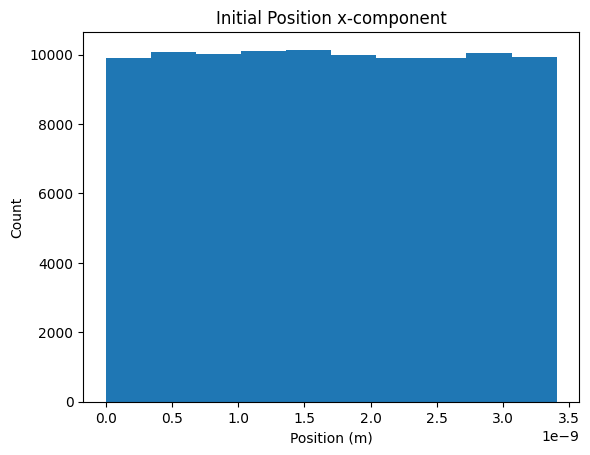

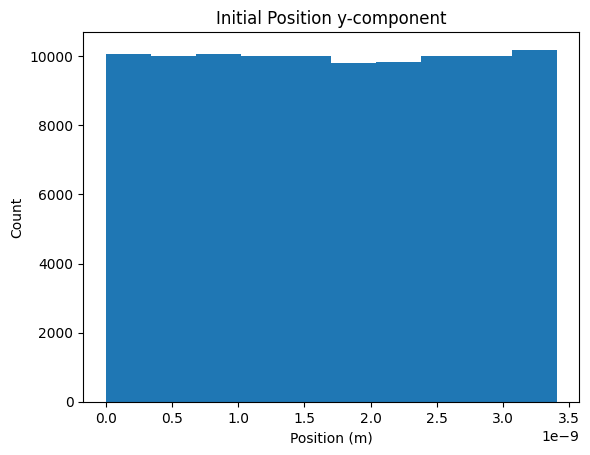

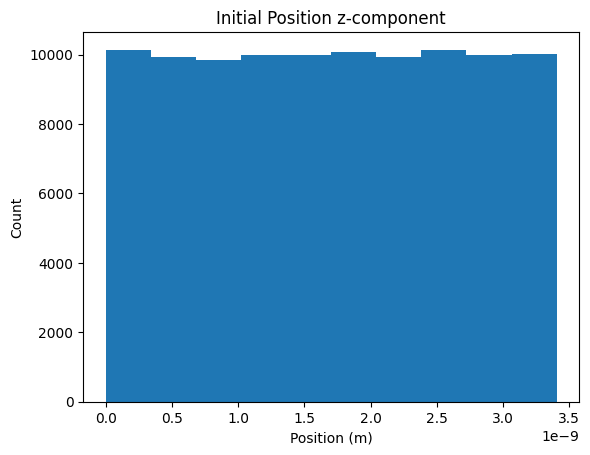

In [27]:
temperature = 50
num_particles = 100000
positions_large, velocities_large = system_init(temperature)

plt.hist(positions_large[:,0])
plt.title("Initial Position x-component")
plt.xlabel("Position (m)")
plt.ylabel("Count")
plt.show()

plt.hist(positions_large[:,1])
plt.title("Initial Position y-component")
plt.xlabel("Position (m)")
plt.ylabel("Count")
plt.show()

plt.hist(positions_large[:,2])
plt.title("Initial Position z-component")
plt.xlabel("Position (m)")
plt.ylabel("Count")
plt.show()

From the above plots, we can see an even distribution across all of the positions in the x, y, and z directions. Additionally, we can see that the particles are all contained within the dimensions of the box, which is $10*\sigma = 3.4*10^{-9}$ meters.

Next, we can look at the particles' velocities.

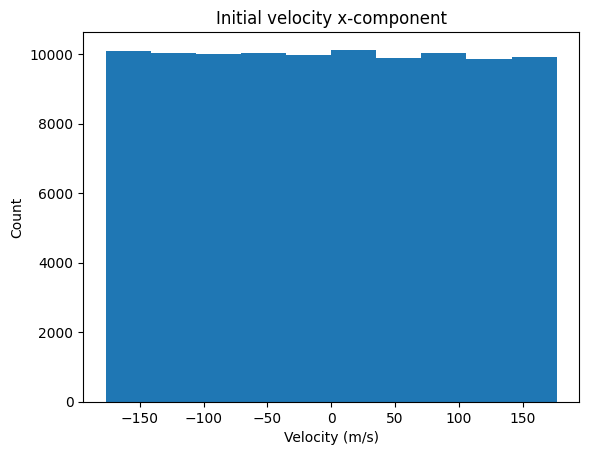

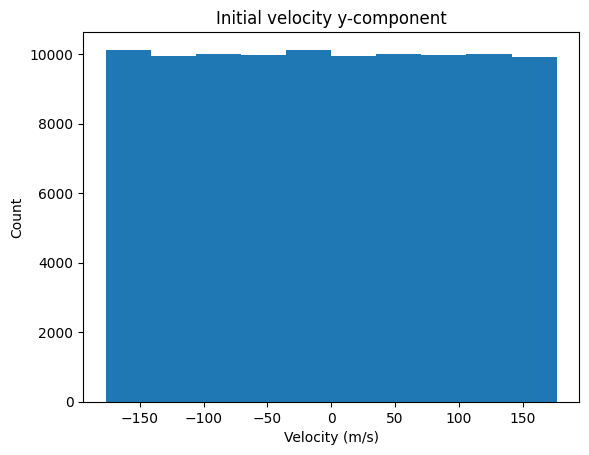

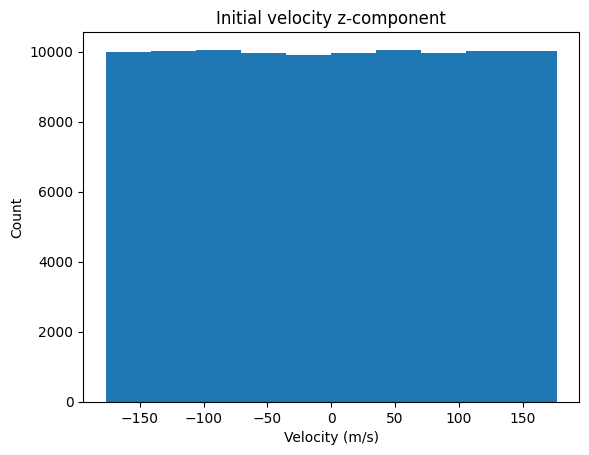

In [8]:
plt.hist(velocities_large[:,0])
plt.title("Initial velocity x-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

plt.hist(velocities_large[:,1])
plt.title("Initial velocity y-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

plt.hist(velocities_large[:,2])
plt.title("Initial velocity z-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

From the above velocity plots, we see an even distribution in all 3 dimensions, so our directions were properly picked uniformly. The appendix shows an example of my earlier code, explains why it had a bias, and shows what these figures would look like if things weren't looking right. Additionally, we can check that the magnitude of the velocities is correct for each particle (showing that our transformation to cartesian components maintained the desired magnitude). This is done below.

In [9]:
velocities_lst = np.sqrt(velocities_large[:,0]*velocities_large[:,0]+velocities_large[:,1]*velocities_large[:,1]+velocities_large[:,2]*velocities_large[:,2])
print("maximum particle speed:", max(velocities_lst))
print("minimum particle speed:", min(velocities_lst))
print("desired particle speed:", np.sqrt(2*1.5*temperature*kb/mass))

maximum particle speed: 176.69132876057395
minimum particle speed: 176.69132876057384
desired particle speed: 176.6913287605739


As we can see, the particles are all at the speed equivalent to the average speed calculated from the temperature of the system.

Now that we've verified the accuracy of our system initialization, let's take a look at the results of our simulations across varying temperatures.

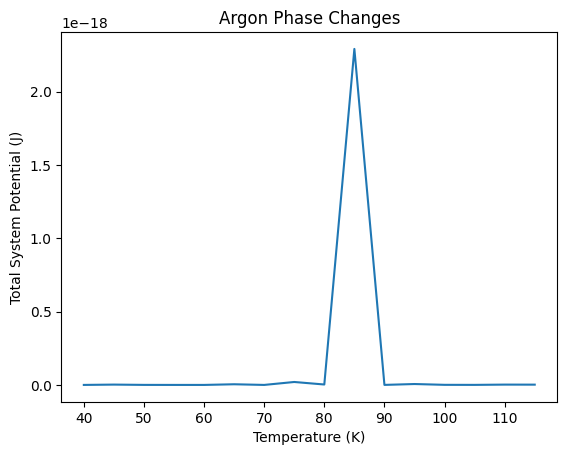

Increased by 2.2883810005001915e-18 Joules at 85 Kelvin


In [28]:
plt.plot(temperatures,pot_temps)
plt.xlabel("Temperature (K)")
plt.ylabel("Total System Potential (J)")
plt.title("Argon Phase Changes")
plt.show()

increase = (pot_temps[9]-pot_temps[8])
print("Increased by", increase, "Joules at 85 Kelvin")

Overall, this doesn't look quite as expected, although we can still extract the phase change(s) from this. We can see a sudden spike in the final potential energy of the system at 85 Kelvin, which isn't surprising. Since the melting point and boiling point of argon are in the 80-90 Kelvin range, what we're likely seeing with that spike is those phase changes, just combined together. Due to the rudimentary nature of my model, I'm not all that surprised to see a quirk like this. Some of the primary reasons why this may be is that I didn't implement a distribution of initial velocities, the number of particles is extremely small at only 10, and the initial positions were random as opposed to in a lattice. The biggest issue with the above plot is that the potential energy drops back down after the phase change, although I think this is likely due to the cutoff distance in the Lennard-Jones potential. If my value for the cutoff distance is too small, then as the particles get farther apart during the phase change, the potential might artificially drop off again as particles are no longer interacting according to the model.

##  Conclusion and Perspectives

Overall, I learned that molecular dynamics can be a helpful method of simulating a system of interacting particles, although the computational power necessary becomes prohibitively large for even a relatively small number of particles. I was able to extract an approximation for when argon changes phases, although it was quite a ways off due to the rudimentary nature of my model. I extracted a value of 85 Kelvin for the phase change of argon, as evident by an increase in the total system potential energy of the value printed above at this point. With the accepted values of the melting point and boiling point at 83.75 and 87.35 Kelvin respectively, this is essentially spot on.

Perhaps the biggest issue I ran into was in my initial attempt to code a molecular dynamics simulation in c++. I had some base code from a github repository created by Anders Hafreager, but after way too many hours of still struggling with compiling code I decided to completely start from scratch with python. If I was to do this again I definitely would start with python from the beginning, since the minor benefit of computational efficiency with c++ just isn't worth it in my opinion. Python is also extremely easy with visualizations, which was another thing that sucked up a lot of my time trying to figure out while I was still attempting to use c++.

Another issue that I came across was in determining the distribution of initial speeds. I at first was looking at applying a Maxwell Boltzmann distribution to the gases, although I later realized that this only really applies to idea gases, and not solids, which is supposed to be my initial phase. Because of this, I applied the average speed to all particles. I also randomized initial positions as opposed to building up a 3D lattice structure due to the time constraints of the project. If I had more time, the first thing I would want to do is apply appropriate spacing to the initial positions to see if that impacts the extracted phase change temperature, and if not I would want to look more into appropriate speed distributions in different states of matter.

## References

Literature/History Sources:
1. Ciccotti et al., "Molecular simulations: past, present, and future (a Topical Issue in EPJB)", The European Physical Journal B, https://link.springer.com/article/10.1140/epjb/s10051-021-00249-x

2. E. Maginn, J. Elliott, "Historical Perspective and Current Outlook for Molecular Dynamics As a Chemical Engineering Tool", https://pubs.acs.org/doi/10.1021/ie901898k

3. "Molecular dynamics", University of Cologne, 2024, https://www.thp.uni-koeln.de/trebst/PracticalCourse/molecular_dynamics.html

4. Xipeng Wang et al., "The Lennard-Jones potential: when (not) to use it, Physical Chemistry Chemical Physics, https://pubs.rsc.org/en/content/articlelanding/2020/cp/c9cp05445f

5. Princeton, "Argon, Ar", https://www.princeton.edu/~maelabs/mae324/glos324/argon.htm

Code/Implementation Sources:
6. Anders Hafreager, github repository, https://github.com/andeplane/molecular-dynamics-fys3150

7. Karthik Karanth, "Generating Random Points in a Sphere", 4 Aug 2018, https://github.com/andeplane/molecular-dynamics-fys3150

## Appendix

Initially, my velocity calculations were done using the following function:

In [29]:
def velocity_init(mag):
    '''
    Determines particle initial velocities in cartesian coordinates
    Takes in magnitude of velocity, randomizes direction in spherical coordinates,
        and calculates then returns cartesian velocity components
    '''
    phi = random.uniform(0,2*math.pi) #spherical coordinate
    theta = random.uniform(0,math.pi) #spherical coordinate
    x = mag*np.sin(theta)*np.cos(phi)
    y = mag*np.sin(theta)*np.sin(phi)
    z = mag*np.cos(theta)
    return x,y,z

If you set up the argon atoms using this method, when analyzing the cartesian components of the velocity you get the following.

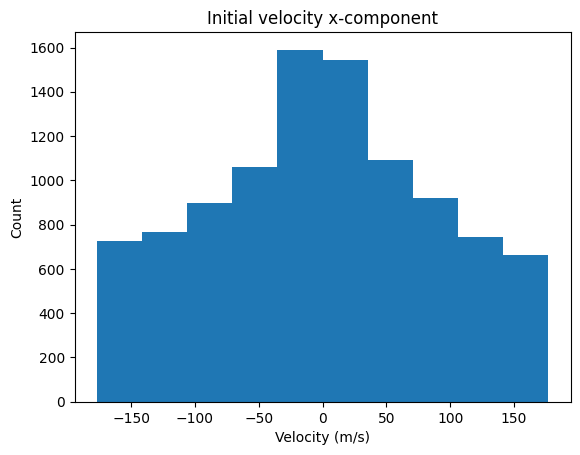

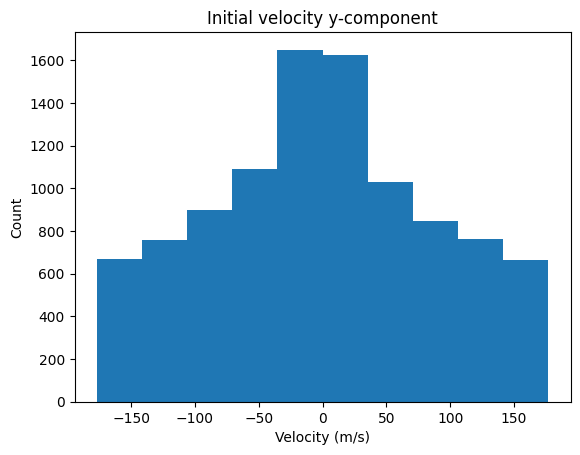

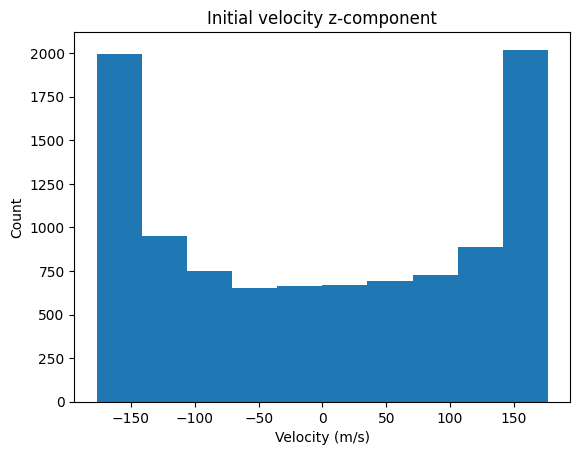

In [30]:
#system setup testing
temperature = 50
num_particles = 10000

positions, velocities = system_init(temperature)

plt.hist(velocities[:,0])
plt.title("Initial velocity x-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

plt.hist(velocities[:,1])
plt.title("Initial velocity y-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

plt.hist(velocities[:,2])
plt.title("Initial velocity z-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

This distribution for the x and y components that peaks around 0 m/s, and the z component that's at a minimum around 0 m/s is caused by an issue with the nonlinear transformation between spherical and cartesian coordinates. To account for this, I had to generate my phi and theta values (angles in spherical coordinates), using a different method proposed by Karthik Karanth in source 7.